In [66]:
!apt-get install -y git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [67]:
!git clone https://github.com/Ajoke23/eos2ta5-model-validation.git

Cloning into 'eos2ta5-model-validation'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 44 (delta 16), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (44/44), 2.90 MiB | 5.51 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [68]:
!pip install rdkit
!pip install umap-learn

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
import os
import sys


In [71]:

# Navigating the data path
%cd eos2ta5-model-validation/Data/Output

df = pd.read_csv("1000molecules_prediction.csv")

# Display the first few rows of the DataFrame
print(df.head())


[Errno 2] No such file or directory: 'eos2ta5-model-validation/Data/Output'
/content/eos2ta5-model-validation/Data/Output/eos2ta5-model-validation/Data/Output
                           key                                       input  \
0  YCYBZKSMUPTWEE-UHFFFAOYSA-L                                      F[Co]F   
1  QYSGYZVSCZSLHT-UHFFFAOYSA-N                     FC(F)(F)C(F)(F)C(F)(F)F   
2  XLYOFNOQVPJJNP-UHFFFAOYSA-N                                           O   
3  MLFKVJCWGUZWNV-UHFFFAOYSA-N                  [NH3+]C(CN(O)N=O)C(=O)[O-]   
4  DFHAXXVZCFXGOQ-UHFFFAOYSA-K  O=C([O-])P(=O)([O-])[O-].[Na+].[Na+].[Na+]   

   probability  
0     0.232585  
1     0.225608  
2     0.080868  
3     0.042456  
4     0.057489  


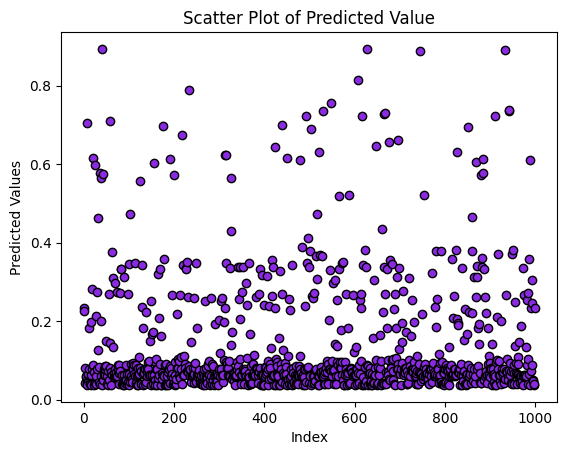

In [72]:
# plotting a scatter plot for the predicted value
plt.scatter(df.index, df['probability'],edgecolors='black', facecolors='#8A2BE2')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted Value')

plt.savefig('scatterplot.png')


Due to the objectives of study, i will be setting threshold probability above which a
compound is considered to inhibit hERG. If the predicted value is >=0.5, it is considered
**hERG blocker** and predicted value <0.5 is considered **hERG nonblocker**

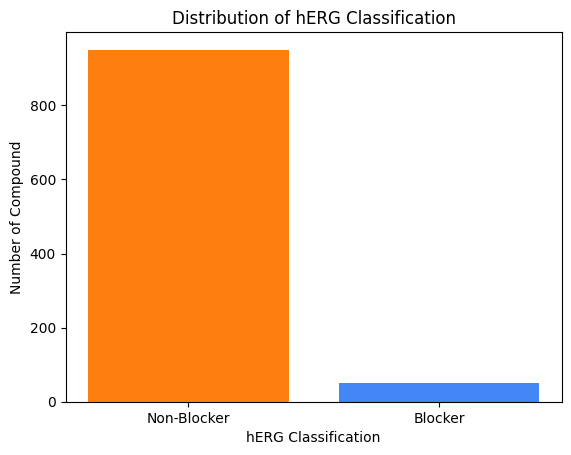

In [73]:

# Setting hERG threshold
threshold = 0.5

# Classification of compound based on threshold probability
df['hERG_classification'] = df['probability'].apply(lambda x: 'Blocker' if x >= threshold else 'Non-Blocker')

# Number of compound in each class
class_counts = df['hERG_classification'].value_counts()

# color presentation for the classifaction in hex format
colors = {'Blocker': '#4287f5', 'Non-Blocker': '#ff7f0e'}

# bar plot to show hERG classification
plt.bar(class_counts.index, class_counts.values, color=[colors[class_] for class_ in class_counts.index])
plt.xlabel('hERG Classification')
plt.ylabel('Number of Compound')
plt.title('Distribution of hERG Classification')
plt.show()


In [74]:
print("Based on the plot, we observe the following:")
print("There are {} compounds classified as hERG Blockers.".format(class_counts['Blocker']))
print("There are {} compounds classified as hERG Non-Blockers.".format(class_counts['Non-Blocker']))

Based on the plot, we observe the following:
There are 50 compounds classified as hERG Blockers.
There are 950 compounds classified as hERG Non-Blockers.


This visualization above is used to know distribution of our molecules that are **hERG Blocker** and **hERG Non-blockers** in the dataset.
From the plot, 95% of the molecules are Non-blockers while 5% of the molecules are blocker.


**SCATTER PLOT WITH TWO NUMERICAL DATA**

Since our predicted output only has one numerical data. To further explore hERG blocker and hERG nonblocker, I would love to implement a  scatter plot with two numerical data which I believe with give better insight.
To achieve this case, I will be featurizing the **input** columns which is in Standardized smiles by using **Morgan Fingerprint** and also reduce the dimensionality features using **Principal Component Analysis (PCA)** and **UMAP**

In [75]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA


# Calculate Morgan fingerprints
def calculate_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)  # Morgan fingerprint radius=2, bit length=1024
        return list(fp)
    else:
        return None

df['morgan_fingerprint'] = df['input'].apply(calculate_morgan_fingerprint)



[06:54:44] WARNING: not removing hydrogen atom without neighbors
[06:54:45] WARNING: not removing hydrogen atom without neighbors
[06:54:45] WARNING: not removing hydrogen atom without neighbors
[06:54:45] WARNING: not removing hydrogen atom without neighbors
[06:54:45] WARNING: not removing hydrogen atom without neighbors
[06:54:45] WARNING: not removing hydrogen atom without neighbors
[06:54:45] WARNING: not removing hydrogen atom without neighbors


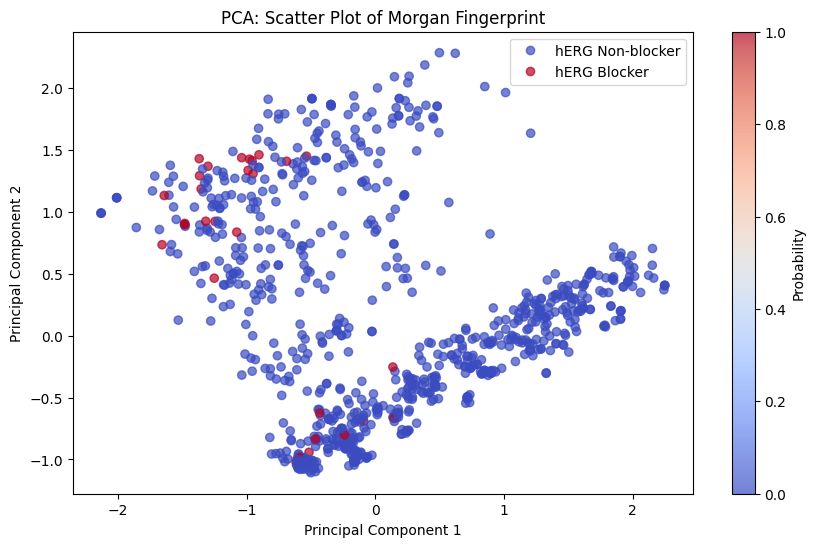

In [76]:

# PCA on Morgan fingerprints
X = df['morgan_fingerprint'].tolist()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['probability']>=0.5, cmap='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Scatter Plot of Morgan Fingerprint')
plt.colorbar(label='Probability')
legend_labels = ['hERG Non-blocker', 'hERG Blocker']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.show()


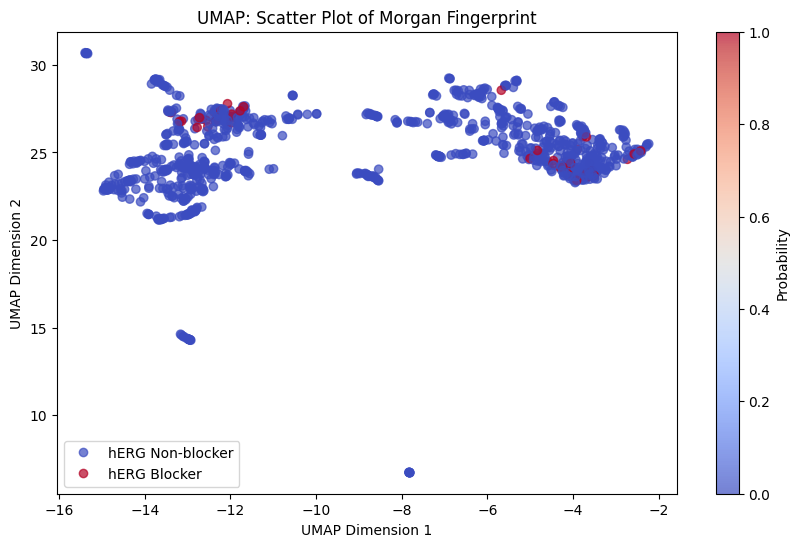

In [77]:
#UMAP for dimensionality reduction
X = df['morgan_fingerprint'].tolist()
mapper = umap.UMAP(n_components=2)
X_umap = mapper.fit_transform(X)

# Plot the scatter plot with legend
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['probability'] >= 0.5, cmap='coolwarm', alpha=0.7)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP: Scatter Plot of Morgan Fingerprint')
plt.colorbar(label='Probability')
legend_labels = ['hERG Non-blocker', 'hERG Blocker']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.show()

